In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from IPython.display import IFrame


%matplotlib inline
%load_ext autoreload
%autoreload 2

# IFrame(src='https://commons.pratt.edu/savi/', width=700, height=400)

In [2]:
import urllib

In [3]:
file_url = 'https://s3.amazonaws.com/tripdata/202003-citibike-tripdata.csv.zip'

In [4]:
urllib.request.urlretrieve(file_url, 'data/input/202003-citibike-tripdata.zip')

('data/input/202003-citibike-tripdata.zip',
 <http.client.HTTPMessage at 0x1261ffc70>)

In [5]:
import zipfile

In [6]:
zipfile.ZipFile(f'data/input/202003-citibike-tripdata.zip').extractall(f'data/input/')

In [7]:
citibike = pd.read_csv('data/input/202003-citibike-tripdata.csv')

# Part 1: data pre-processing

In [195]:
citibike.head(1)

tripduration               starttime                stoptime  \
0          1589 2020-03-01 00:00:03.640 2020-03-01 00:26:32.986   

   start station id     start station name  start station latitude  \
0               224  Spruce St & Nassau St               40.711464   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   

   end station latitude  ...  bikeid    usertype birth year  gender  \
0             40.676969  ...   16214  Subscriber       1980       1   

   start_day  end_day   end_day_2 start_day_2 start_hour  end_hour  
0          1        1  2020-03-01  2020-03-01          0         0  

[1 rows x 21 columns]

In [9]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [10]:
citibike['starttime'] = pd.to_datetime(citibike['starttime'])

In [11]:
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'])

In [12]:
citibike['start_day'] = citibike['starttime'].map(lambda x: x.day)

In [13]:
citibike['end_day'] = citibike['stoptime'].map(lambda x: x.day)

In [14]:
citibike['end_day_2'] = citibike['stoptime'].dt.date

In [15]:
citibike['start_day_2'] = citibike['starttime'].dt.date

In [16]:
citibike['start_hour'] = citibike['starttime'].dt.hour

In [17]:
citibike['end_hour'] = citibike['stoptime'].dt.hour

In [18]:
citibike.shape

(1068457, 21)

## data check- every station only has 1 lat long, for start station and end station

In [19]:
citibike.head(2)

tripduration               starttime                stoptime  \
0          1589 2020-03-01 00:00:03.640 2020-03-01 00:26:32.986   
1           389 2020-03-01 00:00:16.756 2020-03-01 00:06:46.062   

   start station id     start station name  start station latitude  \
0               224  Spruce St & Nassau St               40.711464   
1               293  Lafayette St & E 8 St               40.730207   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   

   end station latitude  ...  bikeid    usertype birth year  gender  \
0             40.676969  ...   16214  Subscriber       1980       1   
1             40.737815  ...   29994  Subscriber       1991       2   

   start_day  end_day   end_day_2 start_day_2 start_hour  end_hour  
0          1        1  2020-03-01  2020-03-01          0         0  
1          1        1  2020-03-01  2020-03-01          0         0  

[2 rows x 21 columns]

In [20]:
number_pickups = citibike.groupby(["start station name", "start station latitude" , "start station longitude", "start_day", "start_hour"]).size().to_frame('size').reset_index()

In [196]:
number_pickups.head(1)

station name  station latitude  station longitude  day  hour  \
0  1 Ave & E 110 St         40.792327           -73.9383    1     7   

   number_pickups  
0               1

In [22]:
number_dropoffs = citibike.groupby(["end station name", "end station latitude" , "end station longitude", "end_day", "end_hour"]).size().to_frame('size').reset_index()

In [23]:
number_dropoffs.rename(columns={'end station name' : 'station name',
                                'end station latitude': 'station latitude',
                                'end station longitude': 'station longitude',
                                'end_day':'day',
                                'end_hour': 'hour',
                                'size': 'number_dropoffs'}, inplace=True)

In [24]:
number_pickups.rename(columns={'start station name' : 'station name',
                               'start station latitude': 'station latitude',
                               'start station longitude': 'station longitude',
                               'start_day': 'day',
                               'start_hour': 'hour',
                              'size': 'number_pickups'}, inplace=True)

In [25]:
number_dropoffs.head(2)

station name  station latitude  station longitude  day  hour  \
0  1 Ave & E 110 St         40.792327           -73.9383    1     0   
1  1 Ave & E 110 St         40.792327           -73.9383    1     2   

   number_dropoffs  
0                1  
1                2

In [26]:
number_pickups.head(2)

station name  station latitude  station longitude  day  hour  \
0  1 Ave & E 110 St         40.792327           -73.9383    1     7   
1  1 Ave & E 110 St         40.792327           -73.9383    1    11   

   number_pickups  
0               1  
1               1

In [27]:
start_complete_test = number_pickups.merge(number_dropoffs,
                                           how='outer',
                                           on=['station name', 'station latitude', 'station longitude',
                                               'day', 'hour'])

In [28]:
start_complete_test.sort_values(by = ['day', 'hour'], ascending=True)

station name  station latitude  station longitude  day  \
358            1 Ave & E 16 St         40.732219         -73.981656    1   
957            1 Ave & E 18 St         40.733812         -73.980544    1   
1511           1 Ave & E 30 St         40.741444         -73.975361    1   
2961           1 Ave & E 62 St         40.761227         -73.960940    1   
3513           1 Ave & E 68 St         40.765005         -73.958185    1   
...                        ...               ...                ...  ...   
358987  W 76 St & Columbus Ave         40.780184         -73.977285   31   
359751  W Broadway & Spring St         40.724947         -74.001659   31   
359851      Wall St & South St         40.704370         -74.006370   31   
361023  West End Ave & W 94 St         40.794165         -73.974124   31   
361126          West Thames St         40.708347         -74.017134   31   

        hour  number_pickups  number_dropoffs  
358        0             4.0              4.0  
957        0             2.0              1.0  
1511       0             1.0              NaN  
2961       0             1.0              1.0  
3513       0             1.0              NaN  
...      ...             ...              ...  
358987    23             NaN              1.0  
359751    23             NaN              1.0  
359851    23             NaN              2.0  
361023    23             NaN              1.0  
361126    23             NaN              2.0  

[362767 rows x 7 columns]

## check that outer join works as intended

In [29]:


start_complete_test[start_complete_test['station name'] == 'Wythe Ave & Metropolitan Ave'].sort_values(by = ['day','hour'], ascending = False).head(8)

station name  station latitude  station longitude  \
291674  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291673  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291672  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291671  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362766  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362765  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
362764  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   
291670  Wythe Ave & Metropolitan Ave         40.716887         -73.963198   

        day  hour  number_pickups  number_dropoffs  
291674   31    21             1.0              NaN  
291673   31    19             2.0              5.0  
291672   31    18             1.0              3.0  
291671   31    17             3.0              NaN  
362766   31    16             NaN              1.0  
362765   31    15             NaN              5.0  
362764   31    14             NaN              2.0  
291670   31    13             1.0              2.0

In [30]:
citibike[citibike['start station name'] == 
         'Wythe Ave & Metropolitan Ave'].sort_values(by = 'starttime', ascending = False)['starttime'].head(11)

1067766   2020-03-31 21:07:48.489
1067012   2020-03-31 19:51:23.426
1066681   2020-03-31 19:30:42.345
1064909   2020-03-31 18:16:58.916
1064155   2020-03-31 17:51:12.594
1064122   2020-03-31 17:50:06.737
1063108   2020-03-31 17:13:33.555
1058098   2020-03-31 13:06:52.793
1056797   2020-03-31 11:33:57.077
1056300   2020-03-31 10:44:38.808
1056230   2020-03-31 10:36:31.443
Name: starttime, dtype: datetime64[ns]

In [31]:
msno.matrix(start_complete_test)

In [32]:
df_citibike = start_complete_test.fillna(0).sort_values(by = ['day','hour','station name'], ascending = True)

In [33]:
from shapely.geometry import Point

## Make geometry column for citibike

In [34]:
df_citibike['geometry'] =df_citibike.apply( lambda row: Point(row['station longitude'], row['station latitude'] ), axis=1)

In [35]:
df_citibike.head()

station name  station latitude  station longitude  day  hour  \
291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
358      1 Ave & E 16 St         40.732219         -73.981656    1     0   
957      1 Ave & E 18 St         40.733812         -73.980544    1     0   
1511     1 Ave & E 30 St         40.741444         -73.975361    1     0   
2961     1 Ave & E 62 St         40.761227         -73.960940    1     0   

        number_pickups  number_dropoffs  \
291675             0.0              1.0   
358                4.0              4.0   
957                2.0              1.0   
1511               1.0              0.0   
2961               1.0              1.0   

                                           geometry  
291675                  POINT (-73.9383 40.7923272)  
358                POINT (-73.98165557 40.73221853)  
957     POINT (-73.9805442094803 40.73381219196632)  
1511         POINT (-73.97536082000001 40.74144387)  
2961                POINT (-73.96094022 40.7612274)

In [36]:
from geopandas import GeoDataFrame

In [37]:
df_citibike = GeoDataFrame(df_citibike, geometry='geometry')

In [38]:
df_citibike = df_citibike.reset_index()

In [39]:
df_citibike['activity'] = df_citibike['number_pickups'] + df_citibike['number_dropoffs']

In [40]:
df_citibike['net_pickups'] = df_citibike['number_pickups'] - df_citibike['number_dropoffs']

In [41]:
df_citibike.head(5)

index      station name  station latitude  station longitude  day  hour  \
0  291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
1     358   1 Ave & E 16 St         40.732219         -73.981656    1     0   
2     957   1 Ave & E 18 St         40.733812         -73.980544    1     0   
3    1511   1 Ave & E 30 St         40.741444         -73.975361    1     0   
4    2961   1 Ave & E 62 St         40.761227         -73.960940    1     0   

   number_pickups  number_dropoffs                    geometry  activity  \
0             0.0              1.0  POINT (-73.93830 40.79233)       1.0   
1             4.0              4.0  POINT (-73.98166 40.73222)       8.0   
2             2.0              1.0  POINT (-73.98054 40.73381)       3.0   
3             1.0              0.0  POINT (-73.97536 40.74144)       1.0   
4             1.0              1.0  POINT (-73.96094 40.76123)       2.0   

   net_pickups  
0         -1.0  
1          0.0  
2          1.0  
3          1.0  
4          0.0

In [42]:
df_citibike.shape

(362767, 11)

In [43]:
df_citibike.crs = {'init' :'epsg:4326'}

In [44]:
df_citibike = df_citibike.to_crs(epsg=2263)

In [45]:
df_citibike.head()

index      station name  station latitude  station longitude  day  hour  \
0  291675  1 Ave & E 110 St         40.792327         -73.938300    1     0   
1     358   1 Ave & E 16 St         40.732219         -73.981656    1     0   
2     957   1 Ave & E 18 St         40.733812         -73.980544    1     0   
3    1511   1 Ave & E 30 St         40.741444         -73.975361    1     0   
4    2961   1 Ave & E 62 St         40.761227         -73.960940    1     0   

   number_pickups  number_dropoffs                        geometry  activity  \
0             0.0              1.0  POINT (1001334.533 227949.114)       1.0   
1             4.0              4.0   POINT (989334.101 206044.065)       8.0   
2             2.0              1.0   POINT (989641.982 206624.752)       3.0   
3             1.0              0.0   POINT (991077.725 209405.575)       1.0   
4             1.0              1.0   POINT (995070.581 216614.806)       2.0   

   net_pickups  
0         -1.0  
1          0.0  
2          1.0  
3          1.0  
4          0.0

# Part 2: Data Analysis - Looking at the sum of daily citibike traffic throughout March

In [207]:
popular_days = df_citibike.groupby(['day'])['activity'].agg('sum').reset_index()

In [210]:
fig = px.line(popular_days,
            x="day", y="activity",
              title='Citibike activity by Day across March')
fig.show()

## Let's define day 14 inclusive as 'Pre-Corona' and everything after that as Post-Corona, since there seems to be a sharp decline after the 14th (other declines earlier could be due to weather)

In [124]:
week1 = df_citibike.loc[df_citibike['day'].isin([2,3,4,5,6])]
week2 = df_citibike.loc[df_citibike['day'].isin([23,24,25,26,27])]

In [125]:
day_of_week = {2:'Mon',3:'Tue',4:'Wed',5:'Thur',6:'Fri'}
day_of_week2 = {23:'Mon',24:'Tue',25:'Wed',26:'Thur',27:'Fri'}

In [126]:
week1 = week1.groupby(['day','hour'])['activity'].agg('sum').reset_index()
week2 = week2.groupby(['day','hour'])['activity'].agg('sum').reset_index()

In [127]:
week2.head()

day  hour  activity
0   23     0     188.0
1   23     1      93.0
2   23     2      45.0
3   23     3      30.0
4   23     4      53.0

In [137]:
week1['day_of_week'] = week1['day'].map(day_of_week) 
week1['day_hour'] = week1["day_of_week"] + "-" + week1["hour"].astype(str)
week1['status'] = 'pre-corona - 2nd thru 6th'
week2['day_of_week'] = week2['day'].map(day_of_week2) 
week2['day_hour'] = week2["day_of_week"] + "-" + week2["hour"].astype(str)
week2['status'] = 'post-corona - 23rd thru 27th'

In [138]:
comparison_workweek = pd.concat([week1,week2])

In [139]:
week1.head(1)

day  hour  activity day_of_week day_hour                     status
0    2     0     468.0         Mon    Mon-0  pre-corona - 2nd thru 6th

In [140]:
comparison_workweek.head(1)

day  hour  activity day_of_week day_hour                     status
0    2     0     468.0         Mon    Mon-0  pre-corona - 2nd thru 6th

In [141]:
comparison_workweek.shape

(240, 6)

In [148]:
fig = px.line(comparison_workweek, x="day_hour", y="activity", color='status',
              title='Citibike activity by hour over 5 weekdays: Pre- and Post-Coronavirus')
fig.show()

![title](days_and_weather.png)

observations:
- morning 8am commuter spike much more subtle post-corona (smaller slope)

- However, the difference could be due to temperature: the post-corona Monday was a really cold day (high 5C) compared to pre-corona Monday (high of 14C), same with Wednesday

- On the other hand, Thursday and Friday (26th & 27th) were significantly warmer than the first Thursday and Friday of the month (the 5th and 6th)- and yet when we compare those 2 weekdays we still see a sharp decline in the morning commuter bumb

- the evening commuter bumb looks different as well, more gradual slope leading to 16 o'clock, but a lot more present than the morning commute spike- perhaps this is a sum of people that are going out post-work for other activities other than commuting

- There are times when the activity is actually higher during the post-corona week than pre-corona, which could be due to good weather or people not having to be in an office

Let's see if we can compare 2 non-Friday pre-corona and post-corona workdays with similar temperature to weed out any effect the weather might have. The warmer post-corona days (Tuesday, Thursday, Friday) seem to have very different patterns, perhaps with still a bit of an evening bump around the eveing commute time.

#### plotting derivative of the slopes might yield more insights

## so, in the spirit of taking temperature out of the equation, let's look at 2 days that had almost identical temperature Thursday the 5th vs Thursday the 19th

In [201]:
def day_comparison(day_1, day_2):
    day1 = df_citibike.loc[df_citibike['day'] == day_1]
    day2 = df_citibike.loc[df_citibike['day']== day_2]
    day1 = day1.groupby(['hour'])['activity'].agg('sum').reset_index()
    day2 = day2.groupby(['hour'])['activity'].agg('sum').reset_index()
    day1['status'] = f"pre-corona, March {day_1}"
    day2['status'] = f"post-corona, March {day_2}"
    comparison_workday = pd.concat([day1,day2])
    fig = px.line(comparison_workday, x="hour", y="activity", color='status',
              title= f'Citibike activity by hour: Pre- and Post-Coronavirus')
    fig.show()

## 2 cold (5C-11C) Thursdays:

In [176]:
day_comparison(5,19)

pretty big difference, especially in morning commuter bump, but the slope duing non-commute hours looks almost identical

## 2 warm (7C-21C) Fridays:

In [177]:
day_comparison(13,27)

like thursday, the slopes look very similar. The morning commute bump is already waning on March 13th, either because it's a Friday, or because the effect of coronavirus is already affecting Citibike activity. Again, we see how morning commute spike is affected more than evening commute spike.

## 2 Sundays- Sunday March 8th is a bit warmer than Sunday March 15th

In [202]:
day_comparison(8,15)

the slopes here are so similar, it could be strictly due to weather- not super helpful

## 2 Saturdays- this time the Post-Corona Saturday is warmer than the pre-Corona one

In [179]:
day_comparison(14,21)

This graph is actually helpful- the 21st is significantly warmer than the 14th (18C vs 14C), and yet ridership is lower, but follows similar patterns, so it's almost certain to say that due to covid-19, fewer riders are using citibikes

In [199]:
def day_comparison3(day_1, day_2, day_3):
    day1 = df_citibike.loc[df_citibike['day'] == day_1]
    day2 = df_citibike.loc[df_citibike['day']== day_2]
    day3 = df_citibike.loc[df_citibike['day']== day_3]
    day1 = day1.groupby(['hour'])['activity'].agg('sum').reset_index()
    day2 = day2.groupby(['hour'])['activity'].agg('sum').reset_index()
    day3 = day3.groupby(['hour'])['activity'].agg('sum').reset_index()
    day1['status'] = f"pre-corona, March {day_1}"
    day2['status'] = f"mid-corona, March {day_2}"
    day3['status'] = f"post-corona, March {day_3}"
    comparison_workday = pd.concat([day1,day2,day3])
    fig = px.line(comparison_workday, x="hour", y="activity", color='status',
              title= f'Citibike activity by hour: Pre- and Post-Coronavirus')
    fig.show()

## Comparing 3 consecutive Wednesdays of almost identical temperature

In [200]:
day_comparison3(5,12,19)

this comparison is very insightful, because the constant of temperature is held the same, and we do see a really big drop in ridership on the third week of March. The decline is most evident during the morning commute.

## Observations thus far:
1. Weather can have a greater impact than covid during non-commute hours
2. Coronavirus did have an impact on Citibike ridership:
    - morning commute spike most impacted
    - evening bump still there, but less of a spike, more gradual increase in citibike activity culminating at 6pm
3. Weekend distributions look the same, just less activity in later weeks of March

# Part 3: GIS visualizations

### to normalize any future graphics displayed over time, I want to know the max and min activity for any given hour this month

In [53]:
activity_max = df_citibike['activity'].max()

In [54]:
activity_max

207.0

In [55]:
activity_min = df_citibike['activity'].min()

In [56]:
activity_min

1.0

In [213]:
# # Part B: merge with Neighborhoods

# from urllib.request import urlopen
# import json

# nyc_nta_geojson = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'


# nta_gdf = gpd.read_file(nyc_nta_geojson)
# nta_gdf = nta_gdf.to_crs(epsg=2263)

# nta_gdf.head(2)

# nta_gdf.drop(nta_gdf[nta_gdf['boro_name'] == 'Staten Island'].index, inplace=True)

# nta_gdf.shape

# ### Join data

#    bikes_in_nyc = gpd.sjoin(  # sjoin stands for spatial join
       
#         df_citibike,
#        nta_gdf,
#         how='right',
#         op='intersects',
#     )

# bikes_in_nyc = bikes_in_nyc.drop(['index_left'], axis=1)

# # bikes_in_nyc = bikes_in_nyc.drop(['index'], axis=1)

# bikes_in_nyc.head()

# bikes_in_nyc.shape

# import contextily as ctx

# import plotly
# plotly.__version__

# import plotly.express as px

# test_choro = bikes_in_nyc[(bikes_in_nyc['day'] == 1) & (bikes_in_nyc['hour'] == 12)]

# test_choro.shape

# fig, ax = plt.subplots(figsize=(14, 14))

# test_choro.to_crs(epsg=3857).plot(
#     ax=ax, 
#     column='activity', 
#     legend=True, 
#     #cmap='Dark2', 
#     alpha=0.7,
#     )


# # ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')

# ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png')


# ax.axis('off')

# ax.set_title('New York City Boroughs', fontdict={'size': 20});

## We now know that there are differences in citibike activity pre- and post-Covid, but we do not know where and at which stations these differences are playing out the most, so we will try to visualize where

In [227]:
def scatter_plot_citibike(day1, hour1, day2, hour2):
    df_citibike_precoro = df_citibike[(df_citibike['day'] == day1) & (df_citibike['hour'] == hour1)]

    fig, ax = plt.subplots(figsize=(15, 15))

    ax = plt.subplot(1, 2, 1)
    df_citibike_precoro.to_crs(epsg=3857).plot(
        ax=ax, 
        column='activity', 
        alpha=0.7,
        vmax = 50
        )


    ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')
    ax.axis('off')
    ax.set_title(f'Traffic at {hour1}, March {day1}', fontdict={'size': 15});



    df_citibike_26_12 = df_citibike[(df_citibike['day'] == day2) & (df_citibike['hour'] == hour2)]


    ax = plt.subplot(1, 2, 2)
    df_citibike_26_12.to_crs(epsg=3857).plot(
        ax=ax, 
        column='activity', 
        alpha=0.7,
        vmax=50
        )


    ctx.add_basemap(ax, url='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')
    ax.axis('off')
    ax.set_title(f'Traffic at {hour2}, March {day2}', fontdict={'size': 15});

In [226]:
scatter_plot_citibike(5,12,26,12)

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://a.basemaps.cartocdn.com/light/13/2411/3076.png

In [221]:
scatter_plot_citibike(13,17,27,17)

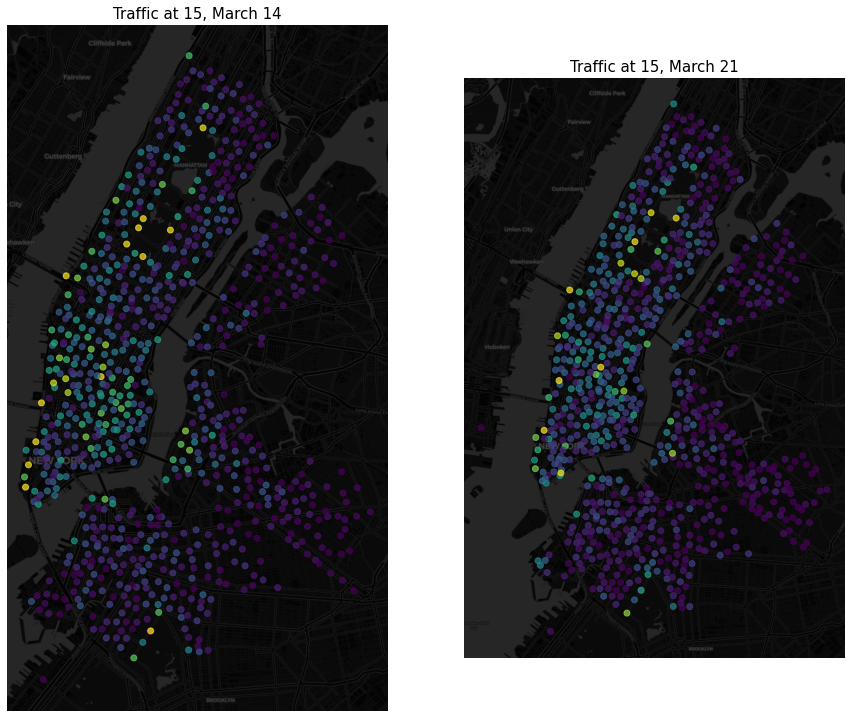

In [222]:
scatter_plot_citibike(14,15,21,15)

# sliders in Plotly - change over time- 1 day

In [73]:
import plotly.graph_objects as go

df_citibike_day21 = df_citibike[df_citibike['day'] == 21]

# activity_max/14

In [85]:
import plotly.express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
df = df_citibike_day21

# fig = px.scatter_mapbox(df, lat="station latitude", lon="station longitude",size=df['activity']*2,
#                                opacity=0.4, size_max=20, zoom=11,
# #                        animation_frame='hour',
#                         width=900, height=900, color_discrete_sequence=["white"])

# fig.add_trace(px.scatter_mapbox(df, lat="station latitude", lon="station longitude", 
# #                         color="net_pickups",
#                         size="activity",
#                   color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=11,
#                        animation_frame='hour', width=900, height=900).data[0])



fig = px.scatter_mapbox(df, lat="station latitude", lon="station longitude", 
#                         color="net_pickups",
                        size="activity",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=11,
                       animation_frame='hour', width=900, height=900)

fig.add_trace(px.scatter_mapbox(df, lat="station latitude", lon="station longitude",size=df['activity']*2,
                               opacity=0.1, color_discrete_sequence=["white"]).data[0])


fig.update_layout(mapbox_style="dark")

fig.show()
